# TensorFlow basics
TensorFlow is a Google library made specifically for neural networks. In this note, we will be introduced to some basics of this main library, as well as the probability module. The topics discussed are:

- [TensorFlow basics](#TensorFlow-basics)
    - [Optimization with standard gradient descent](#Optimization)
    - [Slicing and indexing data set](#Data-sets)
- [TensorFlow Probability](#TensorFlow-Probability)
    - [Generating random data](#Generate-data)
    - [Posterior probability using uniform priors](#Posterior-Probability---Uniform-prior)
    - [Posterior sampling](#Posterior-sampling)



In [ ]:
# pip install -U TensorFlow

In [1]:
import tensorflow as tf

In [2]:
tf.add(1,2)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [71]:
tf.add([1.,2.], [3, 4])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 6.], dtype=float32)>

One thing to note with tensorflow is the types need to be consistent within arrays. Cannot have `1`and `1.` in same array, vector, or matrix. (Well, this worked for me but not him..)

In [4]:
tf.add([1,2], [3,4])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([4, 6])>

In [6]:
tf.square(123)

<tf.Tensor: shape=(), dtype=int32, numpy=15129>

In [9]:
tf.constant([[1,3,4],[5,6,7]])

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 3, 4],
       [5, 6, 7]])>

In [10]:
tf.linalg.inv([[1.,2.], [3.,4.]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-2.0000002 ,  1.0000001 ],
       [ 1.5000001 , -0.50000006]], dtype=float32)>

TensorFlow automatically uses float32 types, but can be changed. 16 is the fastest. Just keep in mind when error pop up.

# Optimization

In [22]:
opt = tf.optimizers.SGD(learning_rate=0.3)

Standard gradient deriviation will get an objective function, find a starting point, and follow the steepest decent down to the global minimum.

In [23]:
var = tf.Variable(2.0)

Variables are the counter-part to constants. Can also be scalars, vectors or matrices. Only difference is they can change, while constants can't.

In [14]:
with tf.GradientTape() as tape:
    y = var**2 +1

In [15]:
tape.gradient(y, var)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [16]:
loss = lambda : var**2 /1.5

In [17]:
loss()

<tf.Tensor: shape=(), dtype=float32, numpy=2.6666667>

In [18]:
opt.minimize(loss, [var])

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [19]:
var

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6666666>

In [25]:
var_vals, loss_vals = [], []
for _ in range(30):       # underscore is a valiad variable name, but means idc,dont worry about it
    opt.minimize(loss, [var])
    var_vals.append(var.numpy())
    loss_vals.append(loss())

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

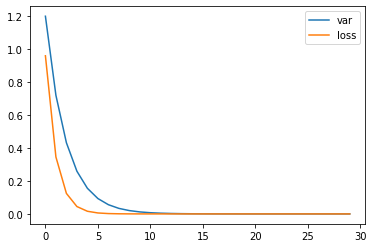

In [29]:
plt.plot(var_vals)
plt.plot(loss_vals)
plt.legend(['var', 'loss'])

# Data sets

Can be nice to use pandas for preprocessing. But in industry, its a good idea to stick to as few libraries as possible. Tensorflow data sets are made for speed, whereas pandas is more for visualizing.


In [30]:
ds = tf.data.Dataset.from_tensor_slices(list(range(12)))

In [31]:
for i in ds.map(tf.square).shuffle(2).batch(3):
    print(i)

tf.Tensor([1 0 9], shape=(3,), dtype=int32)
tf.Tensor([ 4 25 16], shape=(3,), dtype=int32)
tf.Tensor([36 49 81], shape=(3,), dtype=int32)
tf.Tensor([100 121  64], shape=(3,), dtype=int32)


Want to try and do the data manipulations on the graphics card. No need to manipulate on CPU, then transfer over to GPU. 

In [32]:
ds.reduce(0, lambda state, value: state+value)

<tf.Tensor: shape=(), dtype=int32, numpy=66>

In [35]:
state = 0
op = lambda state, value: state+value
for value in ds:
    state = op(state, value)
state

<tf.Tensor: shape=(), dtype=int32, numpy=66>

In [36]:
ds.map(tf.square).reduce(0, tf.add)

<tf.Tensor: shape=(), dtype=int32, numpy=506>

# TensorFlow Probability

We will use this for Bayesian analysis using tensorflow.


In [37]:
# pip install tensorflow_probability

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

# Generate data
Random sample from Binomial with N=60, and $\theta$=0.6

In [3]:
tfd = tfp.distributions

In [67]:
dist = tfd.Binomial(total_count=60, probs=0.6)  # to pull a sample from some random distribution

In [47]:
sample = dist.sample(1)
sample  # happened to match his perfectly, but didnt have to!

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>

# Posterior Probability - Uniform prior

In [50]:
thetas = tf.linspace(start=0., stop=1., num=500)  # have no idea really how these thetas look

In [51]:
# P(theta) -> 
dists = tfd.Binomial(total_count=60, probs=thetas) # my hypothesis is this data follows a Binomial dist.

In [52]:
probs = dists.prob(sample)   # P( datat | hypothesis)

In [53]:
sample /60   # sample=38, 60 observations

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5833333], dtype=float32)>

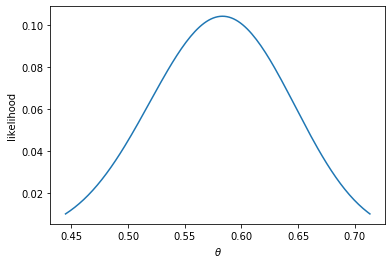

In [54]:
idx = probs > 0.01
plt.plot(thetas[idx], probs[idx])
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
None


# Posterior sampling
Start by generating categorical given my probabilities.

In [55]:
?tf.random.categorical

In [56]:
log_prob = dists.log_prob(sample)
N = 10000    # want 10000 samples from our posterior, sample according to curve to hypothesis

In [25]:
tf.random.categorical(log_prob, N)

InvalidArgumentError: logits should be a matrix, got shape [500] [Op:Multinomial]

In [58]:
idx = tf.random.categorical([log_prob], N)

Will return an index (or indexes, depending on N) responding to the categories

In [59]:
tf.random.categorical(tf.math.log([[0.3, 0.7]]), 10)

<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)>

From these indexes, i need to get back the hypothesis.

In [60]:
theta_sample = tf.gather(thetas, idx)

(array([  43.,  216.,  776., 1712., 2679., 2489., 1516.,  478.,   83.,
           8.]),
 array([0.3687375 , 0.41262525, 0.45651305, 0.5004008 , 0.5442886 ,
        0.58817637, 0.6320641 , 0.6759519 , 0.7198397 , 0.7637274 ,
        0.8076152 ], dtype=float32),
 <a list of 10 Patch objects>)

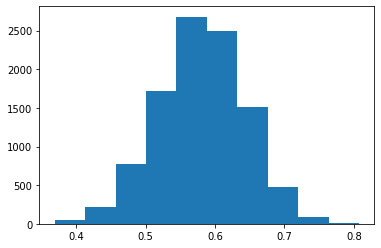

In [61]:
plt.hist(theta_sample)

The exact same as the curve we got above.

In [62]:
posterior_sample = tfd.Binomial(total_count=60, probs=theta_sample).sample(1)[0,0,:]

(array([   4.,   31.,  231.,  913., 2090., 2967., 2327., 1143.,  267.,
          27.]), array([13., 17., 21., 25., 29., 33., 37., 41., 45., 49., 53.],
       dtype=float32), <a list of 10 Patch objects>)

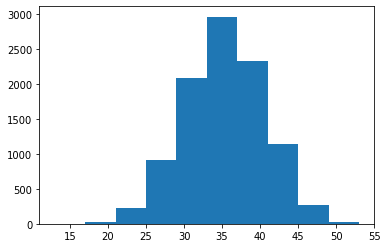

In [63]:
plt.hist(posterior_sample)

In [64]:
unique, idxs, counts = tf.unique_with_counts(posterior_sample)

<BarContainer object of 40 artists>

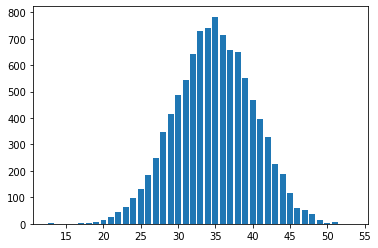

In [65]:
plt.bar(unique, counts)

In [66]:
sample  # peak matches sample

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>

Does my original model make sense with these results? Here we can say yes, since we have a peak again around 35, and roughly the same distribution.